In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import math

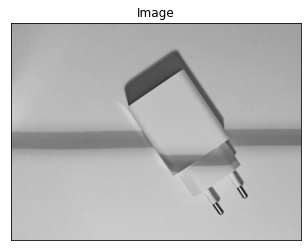

In [70]:
img_name = "Untitled_000028"
#frame = cv2.imread('../imgs/alternate/' + img_name + '.png')
frame = cv2.imread('../imgs/charger_4.jpg')
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(frame_gray, cmap='gray', vmin=0)
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.show()

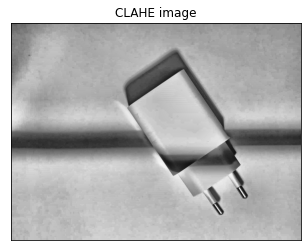

In [71]:
kernel_size = 7
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(kernel_size,kernel_size))
cl1 = clahe.apply(frame_gray)

plt.imshow(cl1, cmap='gray', vmin=0)
plt.title('CLAHE image'), plt.xticks([]), plt.yticks([])
plt.show()

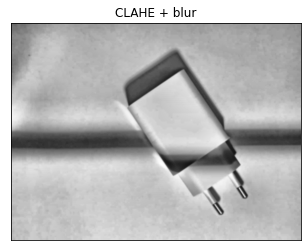

In [72]:
kernel = 9
blur = cv2.GaussianBlur(cl1,(kernel,kernel),0)
plt.imshow(blur, cmap='gray', vmin=0)
plt.title('CLAHE + blur'), plt.xticks([]), plt.yticks([])
plt.show()

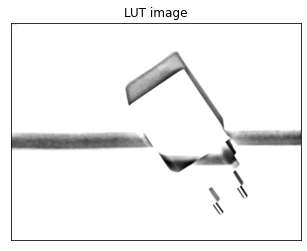

In [73]:
lookUpTable = np.empty((1,256), np.uint8)
gamma = 2
for i in range(256):
    lookUpTable[0,i] = np.clip( 3*i - 60 , 0 , 255)
lut_img = cv2.LUT(blur, lookUpTable)

plt.imshow(lut_img, cmap='gray', vmin=0)
plt.title('LUT image'), plt.xticks([]), plt.yticks([])
plt.show()

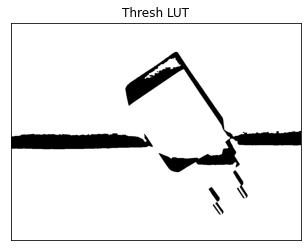

In [74]:
ret,thres = cv2.threshold(lut_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thres, cmap='gray', vmin=0)
plt.title('Thresh LUT'), plt.xticks([]), plt.yticks([])
plt.show()

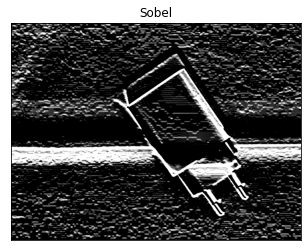

In [75]:
imgWithSobelX = cv2.Sobel(blur, cv2.CV_8U, 1, 0, ksize=5)
imgWithSobelY = cv2.Sobel(blur, cv2.CV_8U, 0, 1, ksize=5)

abs_grad_x = cv2.convertScaleAbs(imgWithSobelX)
abs_grad_y = cv2.convertScaleAbs(imgWithSobelY)
grad = cv2.addWeighted(abs_grad_x, 0.1, abs_grad_y,0.9, 0)

plt.imshow(imgWithSobelY, cmap='gray', vmin=0)
plt.title('Sobel'), plt.xticks([]), plt.yticks([])
plt.show()

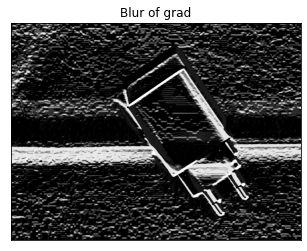

In [76]:
kernel = 7
blur_new = cv2.GaussianBlur(grad,(kernel,kernel),0)
plt.imshow(grad, cmap='gray', vmin=0)
plt.title('Blur of grad'), plt.xticks([]), plt.yticks([])
plt.show()

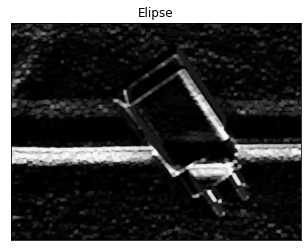

In [77]:
kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(10,10))
ellipse = cv2.morphologyEx(blur_new, cv2.MORPH_OPEN, kernel)

plt.imshow(ellipse, cmap='gray', vmin=0)
plt.title('Elipse'), plt.xticks([]), plt.yticks([])
plt.show()

In [78]:
thres = ~thres
thres2 = cv2.dilate(thres,(3,1),iterations = 10)

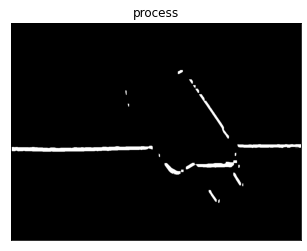

In [79]:
process = cv2.bitwise_and(ellipse,ellipse,mask=thres2)
_,process = cv2.threshold(process,127,255,cv2.THRESH_BINARY)

plt.imshow(process, vmin=0, cmap='gray')
plt.title('process'), plt.xticks([]), plt.yticks([])
plt.show()

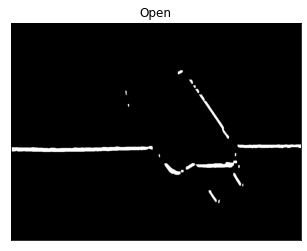

In [80]:
opening = cv2.morphologyEx(process,cv2.MORPH_OPEN,(25,25))
plt.imshow(opening, vmin=0, cmap='gray')
plt.title('Open'), plt.xticks([]), plt.yticks([])
plt.show()

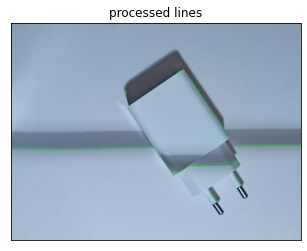

True

In [81]:
frame_gray_copy = frame.copy()

contours, hierarchy = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(frame_gray_copy, contours, -1, (0,255,0), 1)
plt.imshow(frame_gray_copy, vmin=0, cmap='gray')
plt.title('processed lines'), plt.xticks([]), plt.yticks([])
plt.show()
cv2.imwrite('../imgs/contours_' + img_name +'.jpg',frame_gray_copy)

In [82]:
frame_gray_copy = frame.copy()

lines = []

for cnt in contours:
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    box_2 = sorted(box , key=lambda k: k[1])[:2]
    points = sorted(box_2 , key=lambda k: k[0])
    p1,p2 = points
    lines.append([[p1[0],p1[1], p2[0],p2[1]]])
    cv2.drawContours(frame_gray_copy,[box],0,(0,0,255),2)
cv2.imwrite('../imgs/boxes_' + img_name +'.jpg',frame_gray_copy)

True

In [18]:
new_contours = []

current_cnt = None
dist = 100000
height,width = frame.shape[:2]
pos = (0,height/2)

for cnt in contours :
    for point in cnt:
        d = math.dist(point[0], pos)
        if d < dist:
            dist = d
            current_cnt = cnt
new_contours.append(current_cnt)

while current_cnt is not None:
    pos = tuple(current_cnt[current_cnt[:,:,0].argmax()][0])
    new_cnt = None
    dist = 100000
    for cnt in contours :
        for point in cnt:
            d = math.dist(point[0], pos)
            if point[0][0] <= pos[0]:
                continue
            if d < dist:
                dist = d
                new_cnt = cnt
    if new_cnt is not None:
        new_contours.append(new_cnt)
    current_cnt = new_cnt

In [19]:
frame_gray_copy = frame.copy()

cv2.drawContours(frame_gray_copy, new_contours, -1, (0,255,0), 1)

cv2.imwrite('../imgs/new_countors_' + img_name +'.jpg',frame_gray_copy)

True